In [125]:
import numpy as np
import matplotlib.pyplot as plt
import sjoert.stellar
import pandas as pd
import os
from tqdm import tqdm
from astropy import coordinates as coord
from scipy.optimize import curve_fit
import forced_phot as fp #import flux_jy, chi2, gaussian, chi2_peak_finder
from scipy.constants import h,c,k
import json

sjoertpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\Sjoert_Flares'

The below shouldn't be in the class but should be the loop in which the class is called.

In [126]:
test_ztf = 'ZTF18aavummp'
cwd = os.getcwd()
dir = cwd
while not dir.endswith('First Research Project\\Data'):
    cwd = os.path.split(cwd)[0]
    dir = cwd + "\\Data"
banlist = set(['DOWNLOADED','EMPTY','dump'])
iterlist = sorted(set(os.listdir(dir)) - banlist)

for folder in iterlist:
    folder_dir = os.path.join(dir,folder)
    for ztf_name in os.listdir(folder_dir):
        # call the class
        pass


In [127]:
names = ['log10(Fp)', 't_0', 'log10(sigma_rise)', 'log10(tau_dec)', 'F_0', 'log10(T)']
params_names = ['F_p', 't_0', 'sigma_rise','tau_dec', 'F_0', 'T', 'nu_0']
log_names = ['log10_'+params_names[i] for i,name in enumerate(names) if 'log10' in name]


In [128]:
class ZTF_forced_phot:
    def __init__(self,ztf_name): #ztf_name may be simply the name or the path leading to where the relevant data is stored if available.
        if "\\" in ztf_name: #ergo a director y was given instead of a name
            ztf_dir = ztf_name #make self(?)
            ztf_name = os.path.split(ztf_dir)[-1]
        else:
            cwd = os.getcwd()
            dir = cwd
            while not dir.endswith('First Research Project\\Data'):
                cwd = os.path.split(cwd)[0]
                dir = cwd + "\\Data"
            banlist = set(['DOWNLOADED','EMPTY','dump'])
            iterlist = sorted(set(os.listdir(dir)) - banlist)

            for folder in iterlist:
                folder_dir = os.path.join(dir,folder)
                if 'Sjoert' in folder_dir: #REMOVE THIS LATER, ONLY FOR TESTING
                    if ztf_name in os.listdir(folder_dir):
                        ztf_dir = os.path.join(folder_dir,ztf_name) #make self (?)
                        break

        # clean_data = pd.read_json(os.path.join(ztf_dir,f"{ztf_name}_clean_data.json")) #make self
        clean_data = pd.read_csv(os.path.join(ztf_dir,f"{ztf_name}_clean_data.txt"),sep='\t',comment='#',names=['time','flux','flux_unc','zeropoint','filter'])
        clean_data.sort_values('time',inplace=True) #sort the data by time for plotting reasons later on
        no_i_mask = clean_data['filter'] != 'ZTF_i' #create the ZTf_i mask
        flux,err = fp.flux_jy(clean_data) #convert the flux and its errors to uJY
        err = np.clip(err,0.01*flux,np.inf) # clip the errors to be at least 1% of the flux
        clean_data['flux'] = flux.values
        clean_data['flux_unc'] = err.values

        flux, err, time = clean_data[['flux','flux_unc','time']].T.to_numpy(dtype=np.float64)


        time_zeropoint = 2458484.5 #JD of 01-01-2019 @ 00:00:00.000
        time_mjd = clean_data['time'] - time_zeropoint
        clean_data['time'] = time_mjd.values #transform time column

        with open(os.path.join(ztf_dir,f"{ztf_name}_clean_log.json")) as f:
            logfile = json.load(f)

        columns = ['sindex', 'field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing', 'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc', 'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime', 'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd', 'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr', 'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap', 'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag', 'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart', 'refjdend', 'procstatus']
        dtypes = [(columns[x],float) for x in range(len(columns))]
        dtypes[4] = ('filter',r'U8')
        for file in os.listdir(ztf_dir):
            if 'batchfp' in file:
                batchrq_string = file
        unclean_data = pd.DataFrame(np.genfromtxt(os.path.join(ztf_dir,batchrq_string),skip_header=53,dtype=dtypes))
        unclean_data = unclean_data[unclean_data['forcediffimfluxunc'] > 0] #these need to be removed or plotting doesn't work, usually not a lot of datapoints.


        #Source: http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=Palomar&gname2=ZTF&asttype=
        g_center = c/ (4746.48 * 1e-10)
        r_center = c / (6366.38 * 1e-10)
        i_center = c / (7867.41 * 1e-10)

        self.clean_filtermasks = [(clean_data['filter'] == 'ZTF_g'), (clean_data['filter'] == 'ZTF_r'), (clean_data['filter'] == 'ZTF_i')]

        chi2_results, peak_ind, t_0_guess, peak_guess = fp.chi2_peak_finder(flux,err,clean_data['time'],time_zeropoint)
        time_mask_pure = (clean_data['time'] > (t_0_guess - 365)) & (clean_data['time'] < (t_0_guess+365*2)) #these are the times we will be fitting on
        time_mask = time_mask_pure * no_i_mask # also filter out ZTF_i measurements
        
        #values for fitting
        flux_fit,err_fit,time_fit,filters_fit = flux[time_mask],err[time_mask],clean_data['time'][time_mask].to_numpy(),clean_data['filter'][time_mask].to_numpy()

        #frequency array and "central" frequency for blackbody ratio correction
        nu_1 = [g_center if f == 'ZTF_g' else r_center for f in filters_fit]
        nu_1 = np.array(nu_1).astype(np.float64)
        nu_0 = np.average([g_center,r_center],weights=[np.sum(filters_fit=='ZTF_g'),np.sum(filters_fit=='ZTF_r')])

        #Initial guesses and boundings for fitting in order: Fp, peak_pos, sigma, tau_dec, F0, T
        #There are seperate initial guesses for g and r only fitting, namely in the baseline
        guesses = [np.log10(np.max(flux_fit)),t_0_guess,1,2.5,0,4]
        guesses_g = [np.log10(np.max(flux_fit)),t_0_guess,1,2.5,np.median(flux[self.clean_filtermasks[0]]),4]
        guesses_r = [np.log10(np.max(flux_fit)),t_0_guess,1,2.5,np.median(flux[np.invert(time_mask) & self.clean_filtermasks[1]]),4]

        boundings = ([1,t_0_guess-100,0,0,np.min(flux[no_i_mask]),3],[np.log10(np.max(flux_fit*2)),t_0_guess+100,4,4,.5*np.max(flux_fit),5]) 
        boundings_g = ([1,t_0_guess-100,0,0,np.percentile(flux[np.invert(time_mask)&self.clean_filtermasks[0]],5),3], #lower bounds
                       [np.log10(np.max(flux_fit*2)),t_0_guess+100,4,4,np.percentile(flux[np.invert(time_mask)&self.clean_filtermasks[0]],95),5]) #upper boundings
        boundings_r = ([1,t_0_guess-100,0,0,np.percentile(flux[np.invert(time_mask)&self.clean_filtermasks[1]],5),3], 
                       [np.log10(np.max(flux_fit*2)),t_0_guess+100,4,4,np.percentile(flux[np.invert(time_mask)&self.clean_filtermasks[1]],95),5]) #upper boundings

        #initializing all the variables that need to be used later on with self.
        self.ztf_name = ztf_name
        self.ztf_dir = ztf_dir

        self.no_i_mask = no_i_mask
        self.time_zeropoint = time_zeropoint
        self.time_mask = time_mask

        self.clean_data = clean_data
        self.flux, self.err, self.time = self.clean_data[['flux','flux_unc','time']].T.to_numpy(dtype=np.float64)
        self.flux_fit,self.err_fit,self.time_fit,self.filters_fit = flux_fit,err_fit,time_fit,filters_fit
        if sum(self.clean_filtermasks[-1]) == 0:
            self.no_i_data = True

        else:
            self.no_i_data = False
        self.logfile = logfile
        self.unclean_data = unclean_data
        self.g_center = g_center
        self.r_center = r_center
        self.i_center = i_center
        self.nu_0, self.nu_1 = nu_0, nu_1
        self.guesses, self.boundings= guesses, boundings
        self.guesses_g, self.guesses_r = guesses_g, guesses_r
        self.boundings_g, self.boundings_r = boundings_g, boundings_r
        self.chi2_results, self.peak_ind, self.t_0_guess, self.peak_guess = chi2_results, peak_ind, t_0_guess, peak_guess
        self.time_mask_pure = time_mask_pure


    def plot_clean_unclean_data(self,clean_ylim=True):

        clean_flux, clean_err, clean_time = self.flux,self.err,self.time
        raw_flux, raw_err, raw_time = self.unclean_data[['forcediffimflux','forcediffimfluxunc','jd']].T.to_numpy(dtype=np.float64)
        raw_flux = sjoert.stellar.mag2flux(self.unclean_data['zpdiff']) * 1e6 * raw_flux
        raw_err = sjoert.stellar.mag2flux(self.unclean_data['zpdiff']) * 1e6 * raw_err
        raw_time -= self.time_zeropoint

        raw_filtersmasks = [(self.unclean_data['filter'] == 'ZTF_g'), (self.unclean_data['filter'] == 'ZTF_r'), (self.unclean_data['filter'] == 'ZTF_i')]
        colors = ['green','red','brown']
        names = ['ZTF g-band','ZTF r-band','ZTF i-band']
        rawlabels = ['Raw data',None,None]

        num_rows = np.sum([ 1 if np.sum(fmask) > 0 else 0 for fmask in raw_filtersmasks])
        fig,axes = plt.subplots(nrows=num_rows,sharex=True,figsize=(8,8))
        plt.suptitle(self.ztf_name,fontsize=14)
        axes[0].xaxis.set_tick_params(which='both', labelbottom=True)
        axes[1].xaxis.set_tick_params(which='both', labelbottom=True)

        lines = []
        labels = []

        for i,ax in enumerate(axes):
            ax.set_title(names[i])
            ax.errorbar(raw_time[raw_filtersmasks[i]],raw_flux[raw_filtersmasks[i]],raw_err[raw_filtersmasks[i]],fmt=',',alpha=0.5,c='gray',label=rawlabels[i],capsize=2)
            if i == 2:
                if self.no_i_data:
                    print("There is no clean ZTF i-band data.")
                else:
                    ax.errorbar(clean_time[self.clean_filtermasks[i]],clean_flux[self.clean_filtermasks[i]],clean_err[self.clean_filtermasks[i]],fmt=',',c=colors[i],label=names[i],capsize=2)
            else:
                ax.errorbar(clean_time[self.clean_filtermasks[i]],clean_flux[self.clean_filtermasks[i]],clean_err[self.clean_filtermasks[i]],fmt=',',c=colors[i],label=names[i],capsize=2)
            
            ax.set_ylabel(r'Flux [$\mu$Jy]',fontsize=12)
            Line, Label = ax.get_legend_handles_labels() 
            lines.extend(Line) 
            labels.extend(Label)
            if clean_ylim:
                if i == 2 and self.no_i_data:
                    pass
                else:
                    ax.set_ylim(1.25*np.min(clean_flux[self.clean_filtermasks[i]]),1.25*np.max(clean_flux[self.clean_filtermasks[i]]))
        
        
        plt.xlabel(f'Time [mjd] w.r.t. JD {self.time_zeropoint}',fontsize=12)
        fig.tight_layout()
        fig.legend(lines,labels,bbox_to_anchor=[1.2,0.6],fontsize=12)
        plt.show()
    
    def BB(self,nu,T):
        #Blackbody spectrum for a certain frequency given in Hz, not an array of values
        factor = 2*h*np.power(nu,3)/(c**2)
        exponent = (h*nu)/(k*T)
        return factor /(np.exp(exponent)-1)
    
    def BB_ratio(self,T,v,v_0):
        return self.BB(v,T)/self.BB(v_0,T)

    def gauss_exp(self,t,nu,nu_0,no_baseline,*p):

        Fp = 10**p[0]
        t_0 = p[1]
        sigma_rise = 10**p[2]
        tau_dec = 10**p[3]
        no_temp = False
        try:
            T = 10**p[5]
        except:
            no_temp = True
        if no_baseline:
            T = 10**p[4]
            no_temp = False
            F_0 = 0
        else:
            F_0 = p[4]

        trel = t - t_0
        gaussian = lambda t1: Fp * np.exp(-(np.square(t1-t_0)/(2*sigma_rise**2))) + F_0
        exp_decay = lambda t1: Fp * np.exp(-(t1-t_0)/tau_dec) + F_0

        function = np.piecewise(t,[trel <= 0,trel>0],[gaussian, exp_decay])
        # print((exp_decay(t[np.abs(t - t_0).argmin()]) - F_0 )/ Fp)
        if no_temp:
            return function
        else:
            return function* self.BB_ratio(T,nu,nu_0) #for plotting it should be specified at what frequency we are looking.
    
        
    #With BB temperature correction, used for comparing to ZTF_g and ZTF_r data
    def gauss_exp_fit(self,t,*p):
        return self.gauss_exp(t,self.nu_1,self.nu_0,False,*p)
    
    def gauss_exp_fit_no_baseline(self,t,*p):
        return self.gauss_exp(t,self.nu_1,self.nu_0,True,*p)

    def gauss_exp_fit_g(self,t,*p):
        return self.gauss_exp(t,self.g_center,self.nu_0,False,*p)
    
    def gauss_exp_fit_r(self,t,*p):
        return self.gauss_exp(t,self.r_center,self.nu_0,False,*p)

    def gauss_exp_fit_for_plot(self,t,v1,v0,*p):
        return self.gauss_exp(t,v1,v0,True,*p)
    
    def gauss_exp_baseline_peak(self,t,t_0,sigma_rise,tau_dec,T,v0,v1,*p):
        #only baseline and peak are fittable, used for i band
        #v0 is the same as before, v1 is the i band central frequency
        Fp = 10**p[0]
        F_0 = p[1]

        trel = t - t_0
        gaussian = lambda t: Fp * np.exp(-(np.square(t-t_0)/(2*sigma_rise**2))) + F_0
        exp_decay = lambda t: Fp * np.exp(-(t-t_0)/tau_dec) + F_0

        function = np.piecewise(t,[trel <= 0,trel>0],[gaussian, exp_decay])
        return function #* self.BB_ratio(T,v1,v0)


    def fit(self,plot=True,fit_i=True):
        # First fit g and r seperately to find the baseline correction.
        popt_g, pcov_g = curve_fit(self.gauss_exp_fit_g,self.time_fit[self.clean_filtermasks[0][self.time_mask]],
                                   self.flux_fit[self.clean_filtermasks[0][self.time_mask]],
                                    p0=self.guesses_g[:-1],bounds=[b[:-1] for b in self.boundings_g],
                                    sigma=self.err_fit[self.clean_filtermasks[0][self.time_mask]],
                                    full_output=False,
                                    absolute_sigma=True) 

        # popt_g, pcov_g = curve_fit(self.gauss_exp_fit_g,self.time[self.clean_filtermasks[0]],
        #                            self.flux[self.clean_filtermasks[0]],
        #                             p0=self.guesses[:-1],bounds=[b[:-1] for b in self.boundings],
        #                             sigma=self.err[self.clean_filtermasks[0]],
        #                             full_output=False,
        #                             absolute_sigma=True) #zet op true
        
        popt_r, pcov_r = curve_fit(self.gauss_exp_fit_r,self.time_fit[self.clean_filtermasks[1][self.time_mask]],
                                self.flux_fit[self.clean_filtermasks[1][self.time_mask]],
                                p0=self.guesses_r[:-1],bounds=[b[:-1] for b in self.boundings_r],
                                sigma=self.err_fit[self.clean_filtermasks[1][self.time_mask]],
                                full_output=False,
                                absolute_sigma=True)
        
        # popt_r, pcov_r = curve_fit(self.gauss_exp_fit_r,self.time[self.clean_filtermasks[1]],
        #                         self.flux[self.clean_filtermasks[1]],
        #                         p0=self.guesses[:-1],bounds=[b[:-1] for b in self.boundings],
        #                         sigma=self.err[self.clean_filtermasks[1]],
        #                         full_output=False,
        #                         absolute_sigma=True) #zet op true
        
        F0_g, F0_g_err = popt_g[-1], np.sqrt(np.diag(pcov_g)[-1])
        F0_r, F0_r_err = popt_r[-1], np.sqrt(np.diag(pcov_r)[-1])


        baseline = [F0_g if self.filters_fit[i] == 'ZTF_g' else F0_r for i in range(len(self.filters_fit))]

        baseline_err = [F0_g_err if self.filters_fit[i] == 'ZTF_g' else F0_r_err for i in range(len(self.filters_fit))]

        # print(f"F_0,g = {F0_g} ± {F0_g_err} \n F_0,r = {F0_r} ± {F0_r_err}")

        #fitting g and r together to get the other parameter values. The data is fitted on transposed data (with subsequent error prop.)
        # but this is not the shown data in the plot.
        popt,pcov = curve_fit(self.gauss_exp_fit_no_baseline,self.time_fit,self.flux_fit - baseline,
                                            p0=self.guesses[:-2]+[self.guesses[-1]],bounds=[b[:-2]+[b[-1]] for b in self.boundings],
                                            sigma=np.sqrt(np.square(self.err_fit) + np.square(baseline_err)),
                                            full_output=False,
                                            absolute_sigma=True)

        perr = np.sqrt(np.diag(pcov))

        if np.sum(np.invert(self.no_i_mask)) == 0:
            fit_i = False
        if fit_i:
   
            i_func_to_fit = lambda t,*p: self.gauss_exp_baseline_peak(t,popt[1],popt[2],popt[3],popt[4],self.nu_0,self.i_center,*p)
            only_i_mask = np.invert(self.no_i_mask)
            i_time = self.clean_data['time'][only_i_mask].values
            i_flux,i_flux_err = self.clean_data['flux'][only_i_mask].values, self.clean_data['flux_unc'][only_i_mask].values

        #Initial guesses and boundings for fitting in order: Fp, peak_pos, sigma, tau_dec, F0, T

            if len(i_flux[np.invert(self.time_mask_pure)[only_i_mask]]) ==0:
                i_guesses = [np.log10(np.max(i_flux)),np.median(i_flux)]

                i_bounds = ([np.log10(0.5*np.max(i_flux)),np.percentile(i_flux,5)],
                        [np.log10(np.max(i_flux*2)),np.percentile(i_flux,95)])

            else:
                i_guesses = [np.log10(np.max(i_flux)),np.median(i_flux[np.invert(self.time_mask_pure)[only_i_mask]])]

                i_bounds = ([np.log10(0.5*np.max(i_flux)),np.percentile(i_flux[np.invert(self.time_mask_pure)[only_i_mask]],5)],
                        [np.log10(np.max(i_flux*2)),np.percentile(i_flux[np.invert(self.time_mask_pure)[only_i_mask]],95)])
            #boundings = ([1,t_0_guess-100,0,0,np.min(flux[no_i_mask]),3],[np.log10(np.max(flux_fit*2)),t_0_guess+100,4,4,.5*np.max(flux_fit),5]) 

            popt_i,pcov_i = curve_fit(i_func_to_fit,i_time,i_flux,
                                            p0=i_guesses,
                                            bounds=i_bounds,
                                            sigma=i_flux_err,
                                            full_output=False,
                                            absolute_sigma=True)
            
            # perr_i = np.sqrt(np.diag(pcov_i))
            # print(popt_i)

        if plot:
            moretimes = np.linspace(min(self.time_fit),max(self.time_fit),1000)

            centers = [self.g_center,self.r_center,self.i_center]
            
            baseline_corr = [F0_g,F0_r,0]
            # popts = [[np.log10(10**popt[0] + b),*popt[1:]] for b in baseline_corr]
            # popts += [*popt[1:]]
            fits_plot = [self.gauss_exp_fit_for_plot(moretimes,c,self.nu_0,*popt) + baseline_corr[i] for i,c in enumerate(centers)]
            if fit_i:
                #order: Fp, peak_pos, sigma, tau_dec, F0, T
                new_popt = [popt_i[0],*popt[1:4],popt_i[1]]#,popt[-1]]
                # print(new_popt)
                # print(popt)
                # print(i_bounds)
                # fits_plot[2] = i_func_to_fit(moretimes,*popt_i)
                fits_plot[2] = self.gauss_exp(moretimes,self.i_center,self.nu_0,False,*new_popt)
                # print(max(fits_plot[2]))
                #    def gauss_exp(self,t,nu,nu_0,no_baseline,*p):



            paramstr = ''
            newnames = [r'log$_{10}$(F$_\mathrm{p}$)',r't$_0$',r'log$_{10}(\sigma_\mathrm{rise}$)',r'log$_{10}(\tau_\mathrm{dec}$)',r'log$_{10}$(T)']
            for i,n in enumerate(newnames):
                paramstr += f'{n} = {popt[i]:.2f} ± {perr[i]:.3f}'
                paramstr += '\n'

            colors = ['green','red','brown']
            labels_ebar = ['ZTF: g-band','ZTF: r-band','ZTF: i-band']
            lines = []
            labels = []

            fig,axes = plt.subplots(nrows=3,sharex=True,figsize=(8,10))

            axes[0].xaxis.set_tick_params(which='both', labelbottom=True)
            axes[1].xaxis.set_tick_params(which='both', labelbottom=True)
            for i,ax in enumerate(axes):
                ax.errorbar(self.clean_data['time'][self.clean_filtermasks[i]],self.clean_data['flux'][self.clean_filtermasks[i]],
                            self.clean_data['flux_unc'][self.clean_filtermasks[i]],
                            fmt='.',c=colors[i],label=labels_ebar[i],capsize=2)
                if i == 0:
                    ax.plot(moretimes,fits_plot[i],c='black',zorder=10,label='Fit')
                else:
                    ax.plot(moretimes,fits_plot[i],c='black',zorder=10)

                if i < 2:#used to be <3. <2 excludes i but < 3 is always true here
                    if i == 0:
                        ax.scatter(self.t_0_guess,self.peak_guess,s=50,marker='x',c='blue',zorder=10,label='Starting point') 
                    else:
                        ax.scatter(self.t_0_guess,self.peak_guess,s=50,marker='x',c='blue',zorder=10) 

        
                # axes[0].legend()
                ax.set_ylabel(r"Flux ($\mu$Jy)",fontsize=12)

                Line, Label = ax.get_legend_handles_labels() 
                # print(Label) 
                lines.extend(Line) 
                labels.extend(Label)
            
            axes[0].hlines(F0_g,min(self.time),max(self.time),linestyles='dashed',colors='black')#,label=r'F$_{0,g} = $' + f'{F0_g:.3f} ± {F0_g_err:.3f}')
            axes[1].hlines(F0_r,min(self.time),max(self.time),linestyles='dashed',colors='black')#,label=r'F$_{0,r} = $' + f'{F0_r:.3f} ± {F0_r_err:.3f}')
            if fit_i:
                axes[2].hlines(popt_i[1],min(self.time),max(self.time),linestyles='dashed',color='black')
                # axes[2].vlines(popt[1],min(self.flux),max(self.flux),linestyles='dashed',color='blue')
                # axes[2].hlines(10**popt_i[0],min(self.time),max(self.time),linestyles='dashed',color='blue')
            # axes[0].text(0.75,0.88,r'F$_{0,g} = $' + f'{F0_g:.2f} ± {F0_g_err:.3f}',transform=axes[0].transAxes,fontsize=10,bbox=dict(facecolor='none', edgecolor='forestgreen', boxstyle='round,pad=0.5'))
            # axes[1].text(0.75,0.88,r'F$_{0,r} = $' + f'{F0_r:.2f} ± {F0_r_err:.3f}',transform=axes[1].transAxes,fontsize=10,bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=0.5'))

            paramstr += r'F$_{0,g} = $' + f'{F0_g:.2f} ± {F0_g_err:.3f}\n'
            paramstr += r'F$_{0,r} = $' + f'{F0_r:.2f} ± {F0_r_err:.3f}'

            axes[-1].set_xlabel(f"Time (mjd - 2458484.5)",fontsize=12)
            axes[-1].text(0.72,0.45,paramstr,transform=axes[-1].transAxes,fontsize=10,backgroundcolor='lightgray',zorder=-1)

            plt.suptitle(self.ztf_name,fontsize=14)
            # axes[1].legend(lines,labels,loc='upper right',fontsize=12)
            fig.legend(lines,labels,bbox_to_anchor=[1.2,0.6],fontsize=12)
            # fig.legend(lines,labels,loc=[0.783,0.166])
            # plt.legend()
            fig.tight_layout()
            plt.show()
        
        self.popt = popt
        self.perr = np.sqrt(np.diag(pcov)) #you never need pcov
        self.popt_r,self.perr_r = popt_r,np.sqrt(np.diag(pcov_r))
        self.popt_g,self.perr_g = popt_g, np.sqrt(np.diag(pcov_g))
        if plot:
            self.fits_plot = fits_plot

        # deg_freedom = len(self.flux_fit) - (len(popt)) #degrees of freedom is no. points - minus parameters (the fitted ones)
        # chi_per_dof = np.round(np.array(chis)/deg_freedom,2)


        # def save_params_to_json(popt,pcov,nu_0,chis,chi_per_dof,ztf_name=None,savepath=None):
        #     errs = np.sqrt(np.diag(pcov))
        #     units = ['uJy','mjd','days','days','uJy','K','Hz']
        #     filter_order = ['ZTF_g','ZTF_r']

        #     params = [10**p if 'log10' in names[i] else p for i,p in enumerate(popt)]
        #     param_errs = [np.log(10)*err*params[i] if 'log10' in names[i] else err for i,err in enumerate(errs)]

        #     log_params = [p for i,p in enumerate(popt) if 'log10' in names[i]]
        #     log_param_errs = [e for i,e in enumerate(errs) if 'log10' in names[i]]

        #     params.append(np.float32(nu_0)) #since nu_0 doesn't have an error(?), add it only now. 
        #     param_errs.append(np.float32(0))

        #     params.extend(log_params)
        #     param_errs.extend(log_param_errs)


            # ordered_params = [[np.float32(params[i]),np.float32(param_errs[i]),params_names[i],units[i]]  if i < len(units) else np.array([np.float32(params[i]),np.float32(param_errs[i])]) for i in range(len(params))]
            # param_dict = dict(zip(params_names,ordered_params))
            # chilist = [[np.float32(chis[i]),np.float32(chi_per_dof[i])] for i in range(len(chis))]
            # param_dict['chi2'] = dict(zip(filter_order,chilist))


            # if savepath is not None:
            #     filename = ztf_name + '_parameters'
            #     with open(os.path.join(savepath,filename),'w') as file:
            #         json.dump(param_dict,file,indent = 4,cls=NumpyEncoder)
            # return param_dict


        




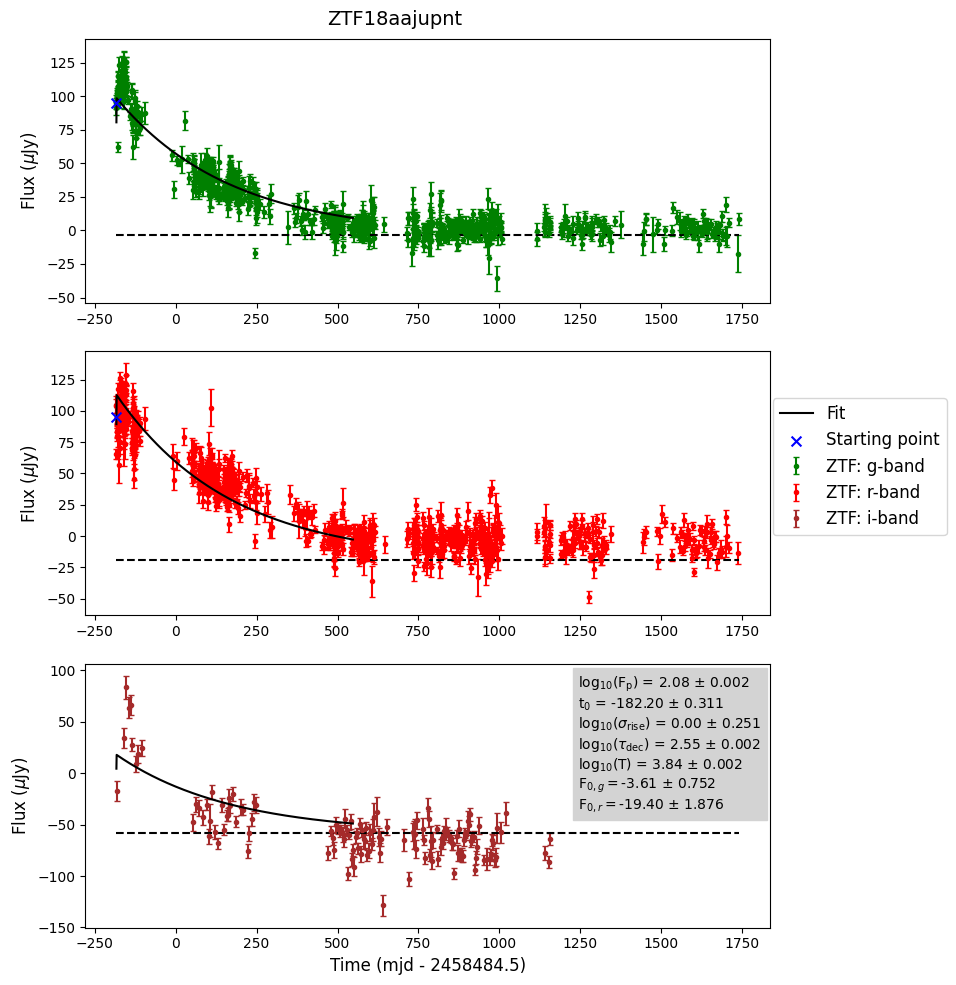

In [129]:
#Timing: 1.18 s ± 30 ms per loop
test_ztf = 'ZTF18aajupnt'
test_ztf_obj = ZTF_forced_phot(test_ztf)

# test_ztf_obj.fit(plot=True,fit_i=False)
test_ztf_obj.fit(plot=True,fit_i=True)
# print('Peak in the plot: ', max(test_ztf_obj.fits_plot[0]))
# print('Fp parameter: ', 10**test_ztf_obj.popt[0])
# print('Fp parameter + F0 param: ', 10**test_ztf_obj.popt[0] + test_ztf_obj.popt_g[-1])
# print('max datapoint: ', np.max(test_ztf_obj.flux_fit[test_ztf_obj.clean_filtermasks[0][test_ztf_obj.time_mask]]))
# print(np.max(test_ztf_obj.flux_fit[test_ztf_obj.clean_filtermasks[0][test_ztf_obj.time_mask]]) - (10**test_ztf_obj.popt[0] + test_ztf_obj.popt_g[-1]))
# print(test_ztf_obj.popt_g[-1])
# ,np.max(test_ztf_obj.flux_fit)



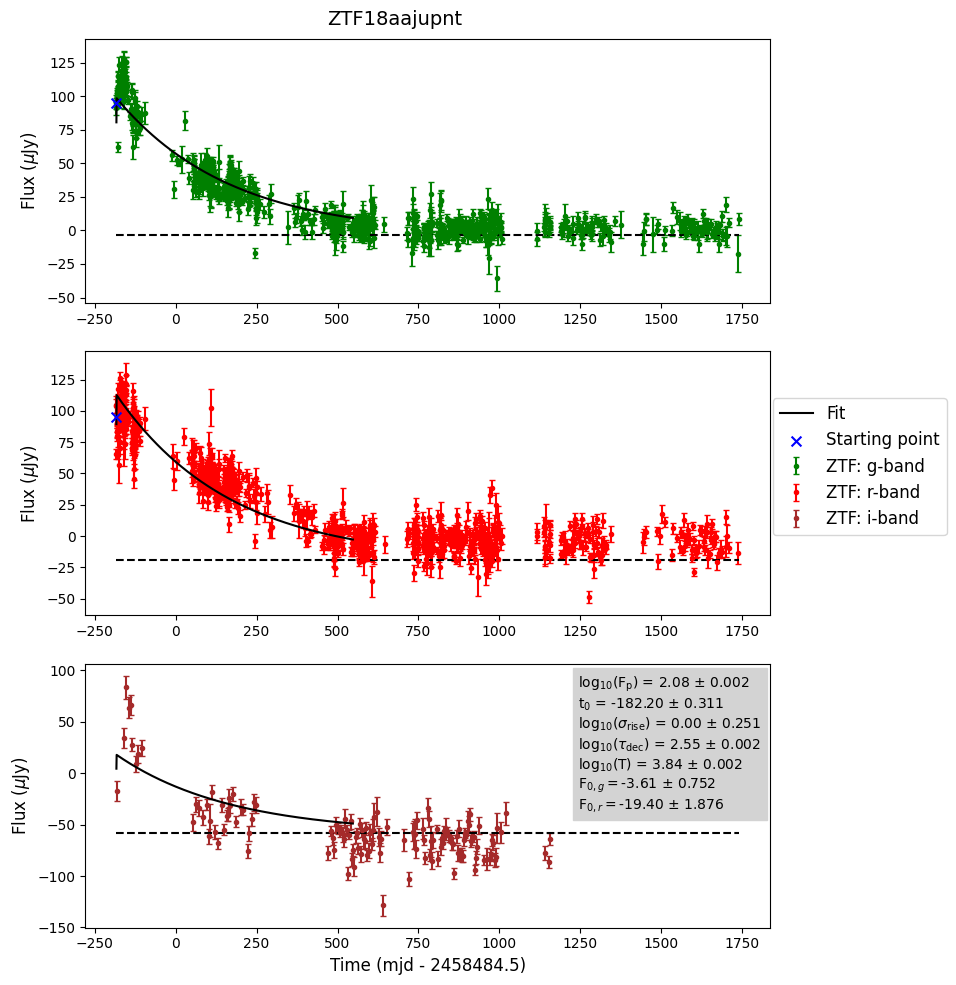

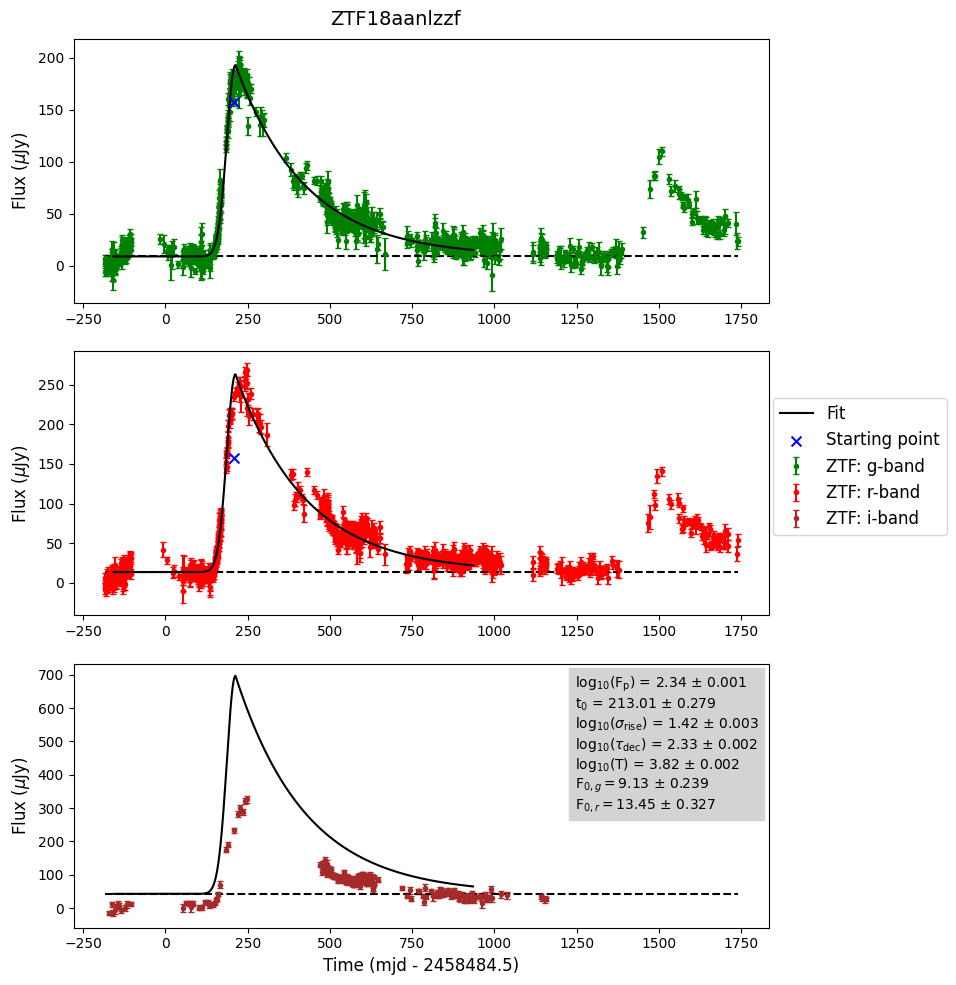

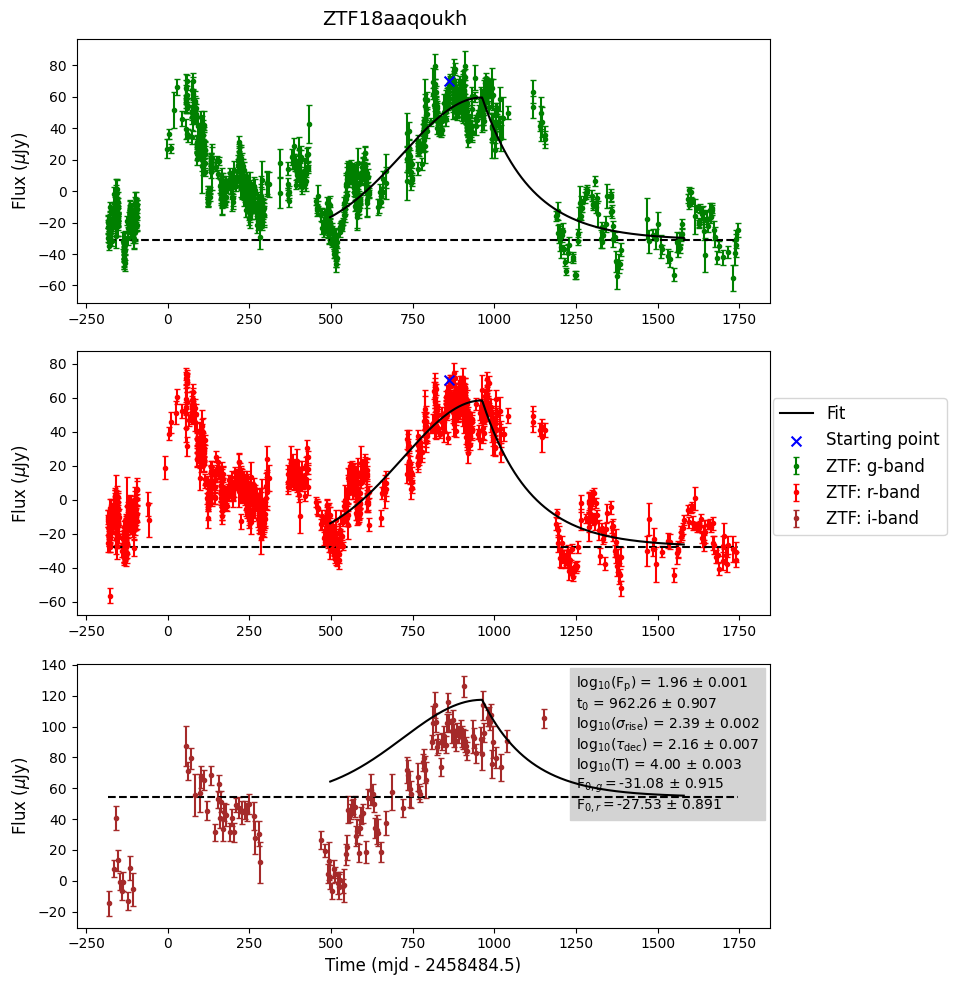

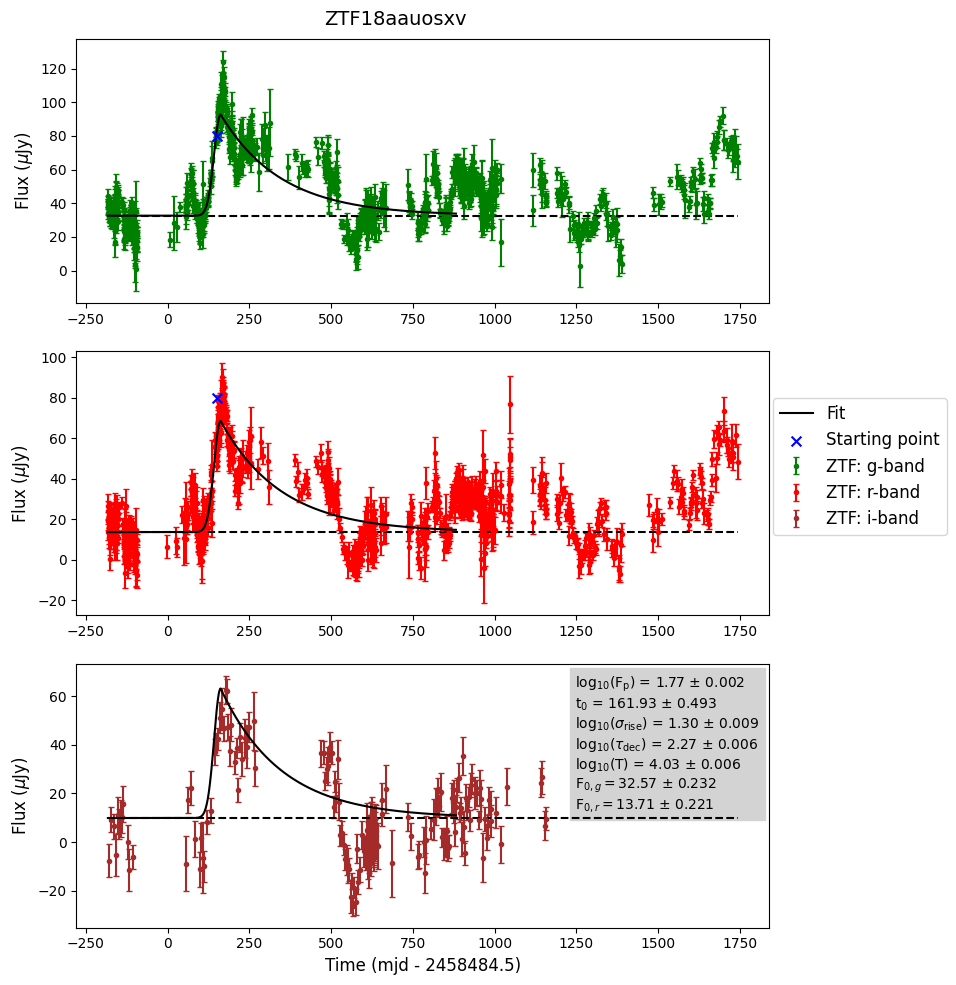

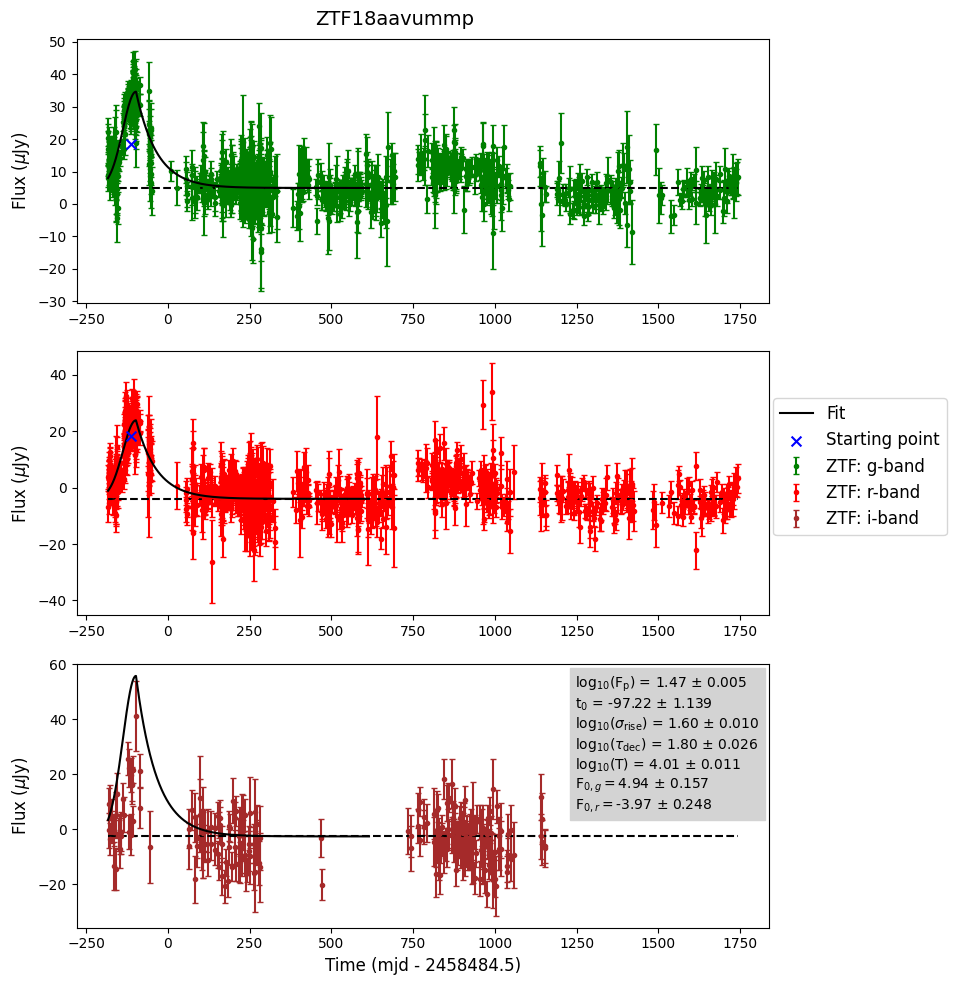

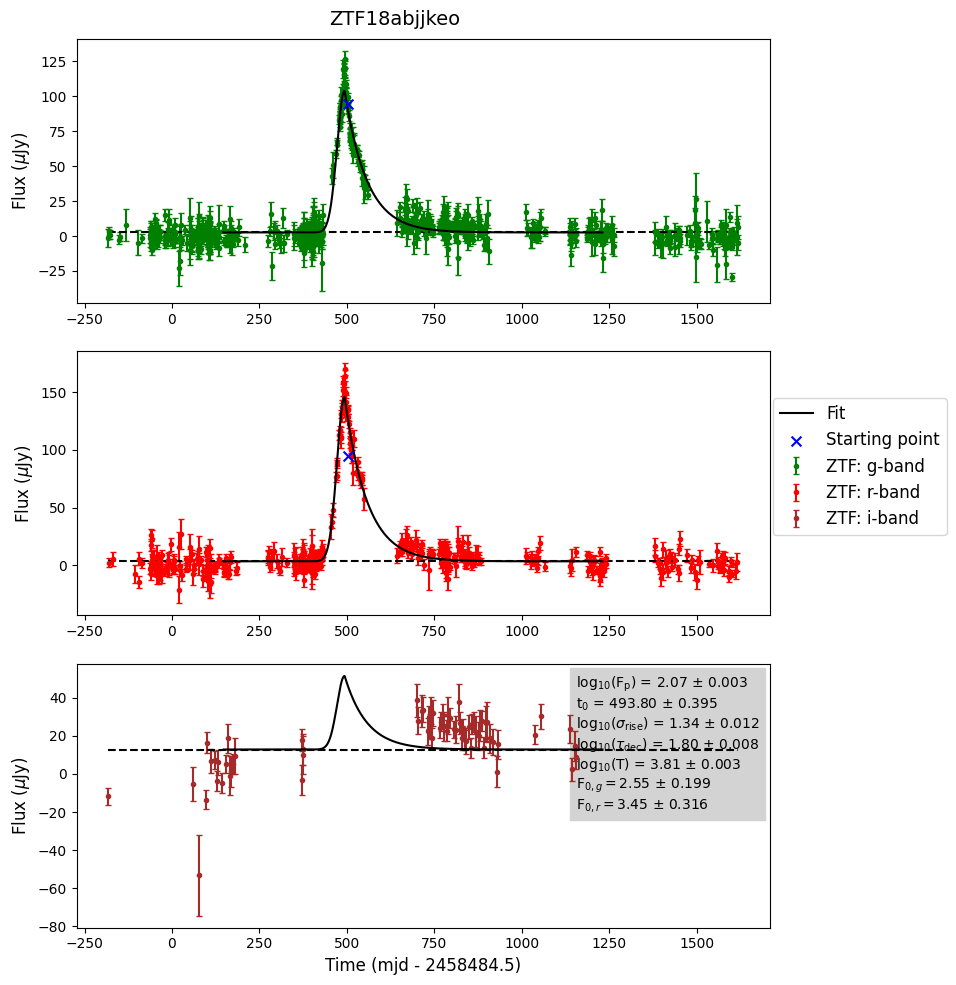

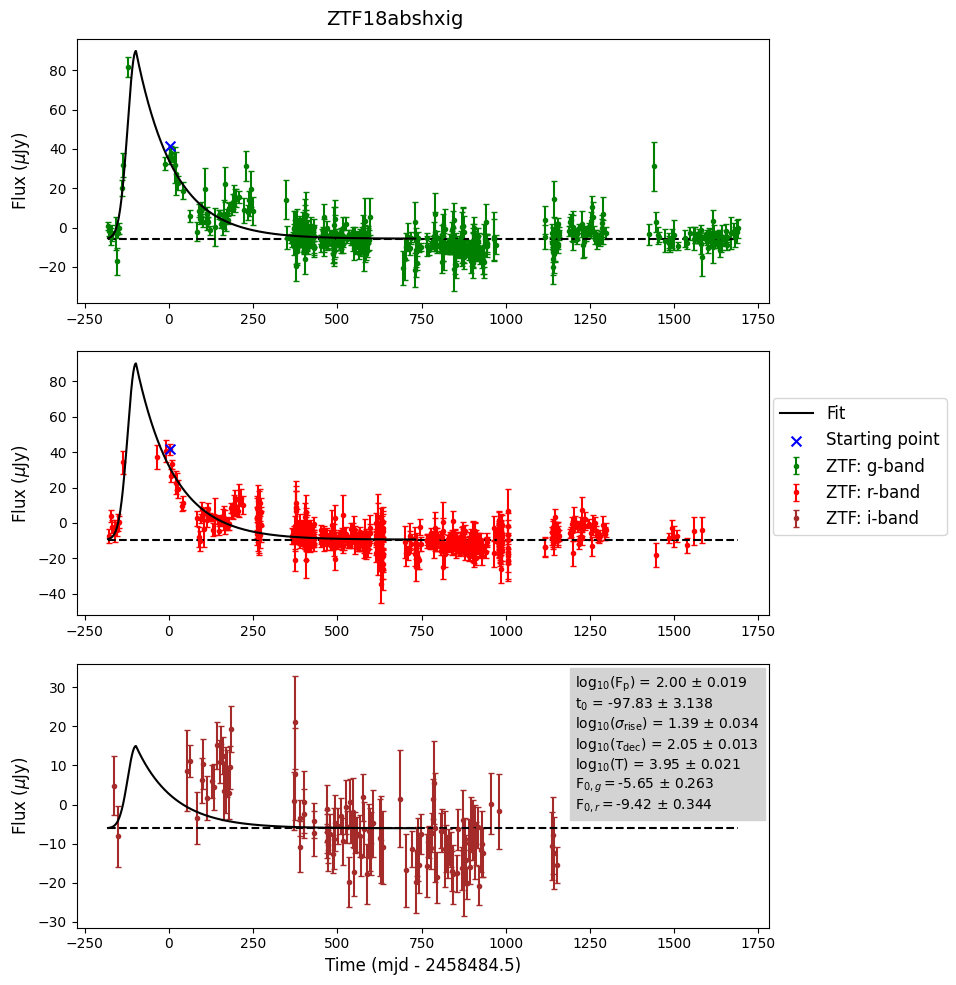

In [130]:
for i,ztf_name in enumerate(os.listdir(sjoertpath)):
    # if i == 0:
    #     continue
    if i > 6:
        break
    if 'ZTF' in ztf_name:
        ztf = ZTF_forced_phot(ztf_name)
        # ztf.plot_clean_unclean_data()
        # try:
        ztf.fit()
        # except:
            # print(f"Error occured in fitting {ztf_name}.")
            # continue

In [131]:
err_ztf = 'ZTF18acbztng'
err_ztf_path = os.path.join(sjoertpath,err_ztf)
# print(ztf_name+"_clean_data.json")
err_data = pd.read_csv(os.path.join(err_ztf_path,err_ztf+"_clean_data.txt"),sep='\t',comment='#',names=['time','flux','flux_unc','zeropoint','filter'])

err_ztf_obj = ZTF_forced_phot(err_ztf)
# err_ztf_obj.plot_clean_unclean_data()
# print(err_ztf_obj.guesses,'\n',err_ztf_obj.boundings)

# err_ztf_obj.plot_clean_unclean_data()
# err_ztf_obj.fit()
# # err_ztf_obj.guesses[:-1]

## special case

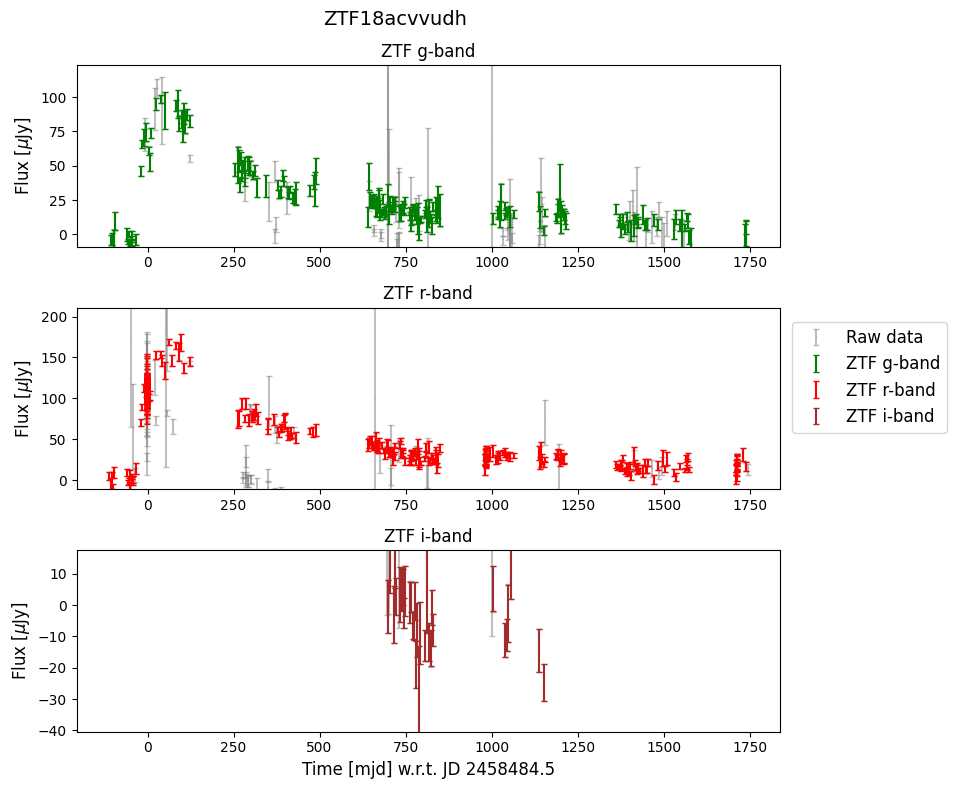

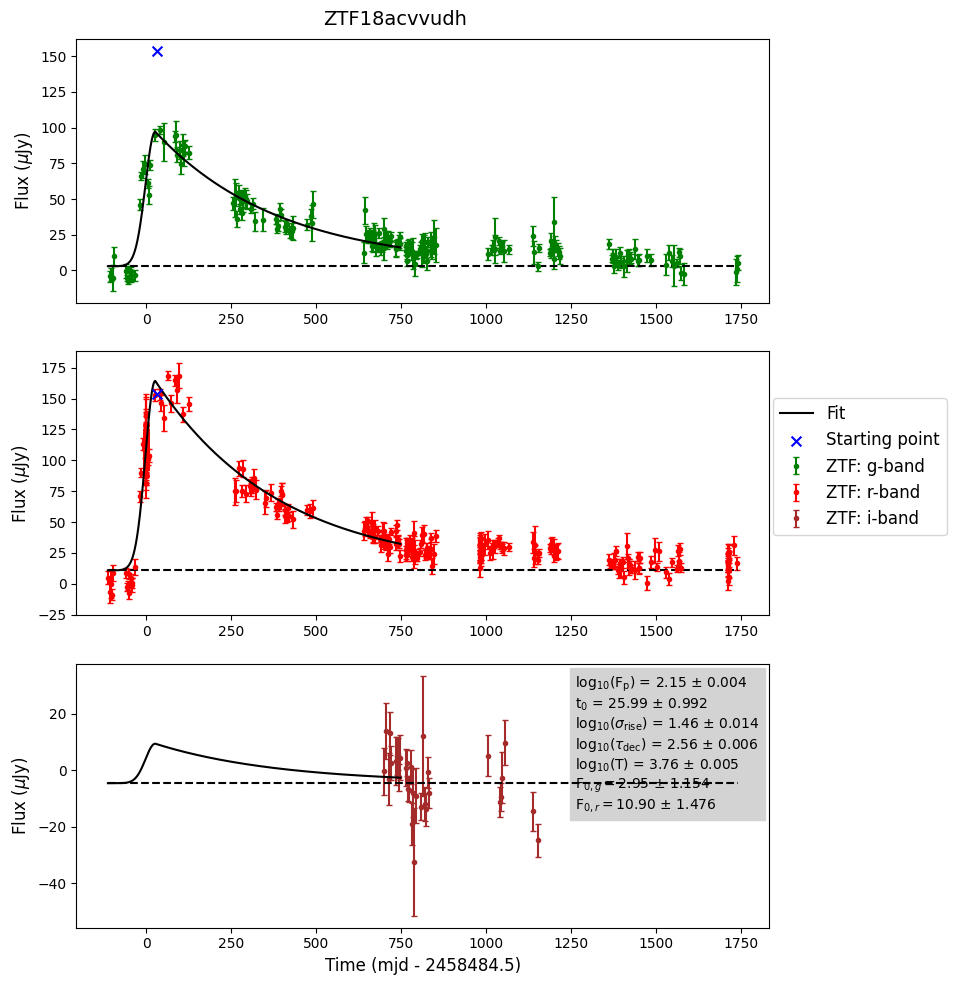

In [132]:
test_ztf = 'ZTF18acvvudh'
test_ztf_path = os.path.join(sjoertpath,test_ztf)
test_ztf_data = pd.read_csv(os.path.join(test_ztf_path,test_ztf+"_clean_data.txt"),sep='\t',comment='#',names=['time','flux','flux_unc','zeropoint','filter'])
test_ztf = ZTF_forced_phot(test_ztf)

test_ztf.plot_clean_unclean_data()
test_ztf.fit()